In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

In [2]:
# import the data
def load_data():
    dataset = CIFAR10(root='data/', download=True, transform=ToTensor())
    test_dataset = CIFAR10(root='data/', train=False, transform=ToTensor())
    return dataset, test_dataset
    

In [3]:
def data_preprocessing(dataset, test_dataset):
    # split into train and validation sets
    torch.manual_seed(43)
    val_size = 5000
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])
    len(train_ds), len(val_ds)
    return train_ds, val_ds

In [4]:
# define training and validation samples
def get_dataloaders(train_ds, val_ds):
    # number of samples per batch
    batch_size=128
    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
    return train_dl, val_dl

In [5]:
# create class with helper methods for validation and training sets
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [6]:
# define cnn
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # combine layers + functions into singular network
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            # flatten
            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [7]:
# transfer model + data to available device
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [8]:
# transfers data + model to available device
def data_transfer(train_dl, val_dl, device, model):
    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)
    to_device(model, device);

In [9]:
# train the model
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [10]:
# list of hyperparameters 
def run_model(train_dl, val_dl, device):

    # instantiate model with initial parameters
    model = to_device(Cifar10CnnModel(), device)
    num_epochs = 10
    opt_func = torch.optim.Adam
    lr = 0.001
    history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
    return history

In [11]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    # plot validation accuracy
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('acc');

In [12]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    # plot training loss
    plt.plot(train_losses, '-bx')
    # plot validation loss
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train', 'val'])
    plt.title('loss');

Files already downloaded and verified
Epoch [0], train_loss: 1.7470, val_loss: 1.3503, val_acc: 0.5047
Epoch [1], train_loss: 1.2151, val_loss: 1.0920, val_acc: 0.5994
Epoch [2], train_loss: 0.9802, val_loss: 0.9214, val_acc: 0.6682
Epoch [3], train_loss: 0.8102, val_loss: 0.8701, val_acc: 0.6910
Epoch [4], train_loss: 0.6757, val_loss: 0.7710, val_acc: 0.7244
Epoch [5], train_loss: 0.5661, val_loss: 0.7294, val_acc: 0.7428
Epoch [6], train_loss: 0.4652, val_loss: 0.6976, val_acc: 0.7629
Epoch [7], train_loss: 0.3701, val_loss: 0.6977, val_acc: 0.7715
Epoch [8], train_loss: 0.2840, val_loss: 0.7743, val_acc: 0.7625
Epoch [9], train_loss: 0.2259, val_loss: 0.8334, val_acc: 0.7717


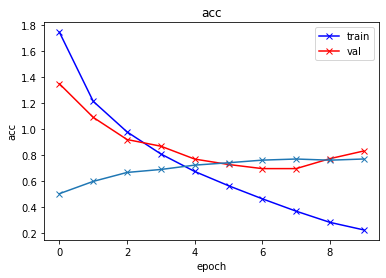

In [15]:
def main():
    dataset, test_dataset = load_data()
    train_ds, val_ds = data_preprocessing(dataset, test_dataset)
    train_dl, val_dl = get_dataloaders(train_ds, val_ds)

    models = Cifar10CnnModel()
    
    # check device
    device = get_default_device()
    trainedModel = run_model(train_dl, val_dl, device)
    
    # plot the model
    plot_losses(trainedModel)
    plot_accuracies(trainedModel)

main()